> ref: https://onlinelibrary.wiley.com/doi/abs/10.1002/mrm.28992
# 功能函数

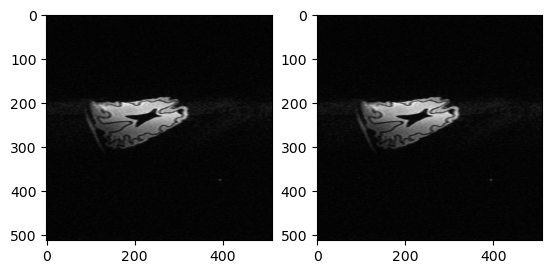

6.94484035388924e-23


In [6]:
import os, time, logging
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def vis_square(data, title=''):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""

    # normalize data for display
    # data = (data - data.min()) / (data.max() - data.min())

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
                (0, 1), (0, 1))  # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant',
                  constant_values=max(1, data.max()))  # pad with ones (white)

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

    plt.imshow(data, cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title)

    return n

def vis_square_annotate(data, rois=[], title=''):
    fig, ax = plt.subplots(figsize=(12, 12), dpi=100)
    n = vis_square(data, title)
    padding = 1  # XXX - vis_square pad one white pixel between images

    for r in rois:
        rect = Rectangle((rois[r][1] * (data.shape[1] + padding) + rois[r][2],
                          rois[r][0] * (data.shape[2] + padding) + rois[r][3]),
                         rois[r][4], rois[r][5], edgecolor='g', fill=False)

        roi = data[rois[r][0] * n + rois[r][1],
              rois[r][3]:(rois[r][3] + rois[r][5]),
              rois[r][2]:(rois[r][2] + rois[r][4])]

        # plt.figure()
        # plt.imshow(roi, cmap='gray')
        # plt.axis('off')

        ax.add_patch(rect)
        ax.annotate('%s Mean:%.4f,StdDev:%.4f' % (r, roi.mean(), roi.std()),
                    rect.get_xy(), color='r', weight='normal',
                    fontsize=10, ha='left', va='baseline')
        
def reconImagesByFFT(kdata, size):
    if isinstance(size, int):
        size = (size, size)

    try:
        # experiments, echoes, slices, views, views2, samples = kdata.shape
        idata = np.fft.fftshift(np.fft.ifftn(kdata, s=(size[0], kdata.shape[4], size[1]),
                                             axes=(3, 4, 5)),
                                axes=(3, 4, 5))
    except Exception as e:
        return []

    idata = np.abs(idata)
    idata /= idata.max()

    images = []
    for e in range(idata.shape[0]):
        for k in range(idata.shape[1]):
            for s in range(idata.shape[2]):
                for v2 in range(idata.shape[4]):
                    images.append(idata[e, k, s, :, v2, :])

    return images
    
def yanglei(kdatas, nbin=8, v=0):
    kdata_obj = kdatas[0]
    kdata_nos = [_ for _ in kdatas[1:] if _ is not None]

    if len(kdata_nos) <= 0:
        return kdata_obj

    if (not isinstance(nbin, int)) or nbin <= 0:
        logging.warning('The nbin(=%d) must be an integer greater than 0.' % (nbin,))
        return kdata_obj

    npb = kdata_nos[0].shape[5] // nbin

    if (nbin * npb) != kdata_nos[0].shape[5]:
        logging.warning('The nbin(=%d) must be divisible by number of samples(=%d).' % (nbin, kdata_nos[0].shape[5]))
    else:
        idata_obj = np.fft.fft(kdata_obj)
        idata_nos = np.array([np.fft.fft(kdata_nos[i]) for i in range(len(kdata_nos))])

        X = idata_nos[:, 0, 0, 0, v, 0, :]
        y = idata_obj[0, 0, 0, v, 0, :]
        c = np.zeros((idata_nos.shape[0], nbin), dtype=y.dtype)

        for i in range(c.shape[1]):
            rng = range(i * npb, (i + 1) * npb)
            _ = np.linalg.lstsq(X[:, rng].T, y[rng], rcond=None)
            c[:, i] = _[0]

        idata_obj -= np.reshape(np.sum(c[:, None, None, None, None, None, :, None] *
                                       idata_nos.reshape((idata_nos.shape[0], idata_nos.shape[1], idata_nos.shape[2],
                                                          idata_nos.shape[3], idata_nos.shape[4], idata_nos.shape[5],
                                                          c.shape[1], -1)),
                                       axis=0),
                                idata_obj.shape)

        kdata_obj = np.fft.ifft(idata_obj)

    return kdata_obj

def loadMrd(fpath):
    try:
        with open(fpath, 'rb') as f:
            mrd = f.read()
    except Exception as e:
        print(e)
        return None

    if len(mrd) < 512:
        return None

    samples=int(0).from_bytes(mrd[0:4], byteorder='little', signed=True)
    views=int(0).from_bytes(mrd[4:8], byteorder='little', signed=True)
    views2=int(0).from_bytes(mrd[8:12], byteorder='little', signed=True)
    slices = int(0).from_bytes(mrd[12:16], byteorder='little', signed=True)
    # 16-18 Unspecified
    datatype=int(0).from_bytes(mrd[18:20], byteorder='little', signed=True)
    # 20-152 Unspecified
    echoes=int(0).from_bytes(mrd[152:156], byteorder='little', signed=True)
    experiments=int(0).from_bytes(mrd[156:160], byteorder='little', signed=True)

    nele = experiments*echoes*slices*views*views2*samples

    if datatype & 0xf == 0:
        dt='u1'
        eleSize = 1
    elif datatype & 0xf == 1:
        dt='i1'
        eleSize = 1
    elif datatype & 0xf == 2:
        dt='i2'
        eleSize = 2
    elif datatype & 0xf == 3:
        dt='i2'
        eleSize = 2
    elif datatype & 0xf == 4:
        dt='i4'
        eleSize = 4
    elif datatype & 0xf == 5:
        dt='f4'
        eleSize = 4
    elif datatype & 0xf == 6:
        dt='f8'
        eleSize = 8
    else:
        print('Unknown data type in the MRD file!')
        return None
    if datatype & 0x10:
        eleSize *= 2

    #
    # XXX - The value of NO_AVERAGES in PPR cannot be used to
    #       calculate the data size.
    #
    posPPR = mrd.rfind(b'\x00')
    if posPPR == -1:
        print('Corrupted MRD file!')
        return None
    posPPR += 1
    dataSize = posPPR - 512 - 120
    if dataSize < nele * eleSize:
        print('Corrupted MRD file!')
        return None

    navg = dataSize // (nele * eleSize)

    if navg > 1:
        data = np.zeros((experiments,echoes,slices,views,views2,samples),
                        dtype=(np.complex128 if dt == 'f8' else np.complex64) if (datatype & 0x10) else (np.float64 if dt == 'f8' else np.float32))

    offset = 512
    for i in range(navg):
        x = np.frombuffer(mrd[offset:],
                          dtype=[('re', '<'+dt), ('im', '<'+dt)] if (datatype & 0x10) else ('<'+dt),
                          count=nele)
        if dt in ('f4', 'f8'):
            pass
        else:
            x = x.astype(np.float32)

        if datatype & 0x10:
            if dt in ('f8',):
                x = x.view(np.complex128)
            else:
                x = x.view(np.complex64)

        x = x.reshape((experiments,echoes,slices,views,views2,samples))

        offset += nele * eleSize

        if navg > 1:
            data += x

    if navg > 1:
        data /= navg
    else:
        data = x

    return data

def load_data(scan_or_noise='scan', root='datasets/HYC', set_id=1, exp_id=1):
    path = os.path.join(root, f'set {set_id}', f'{scan_or_noise} data', f'exp{exp_id}')  # set 1，exp1注意空格
    files = os.listdir(path)
    return [loadMrd(os.path.join(path, file)) for file in files]
        
def editer(kdatas, W=None, ksz1=(0, 0), ksz2=(0, 0), threshold=0.5):
    kdata_obj = kdatas[0]
    kdata_nos = [_ for _ in kdatas[1:]]
    
    experiments, echoes, slices, views, views2, samples = kdata_obj.shape
    Nc = len(kdata_nos)
    
    if W is None:
        W = views
    Nw = views // W
    if W * Nw != views:
        print(f"error: W({W}) * N_w({Nw}) != views({views})")
        return
    
    def conv(win, noise, dx, dy, id=0):
        win_l, win_r = win
        return np.vstack([np.vstack([
                    np.concatenate([nos[0, 0, 0, y:y+dy, id, x:x+dx].flatten() for nos in noise]) 
                for x in range(samples)]) for y in range(win_l, win_r)])
        
    # H
    ksz_x, ksz_y = ksz1
    delta_x, delta_y = ksz_x*2+1, ksz_y*2+1
    pad_nos = [np.pad(_, ((0, 0), (0, 0), (0, 0), (ksz_y, ksz_y), (0, 0), (ksz_x, ksz_x))) for _ in kdata_nos]
    H = np.empty((Nc * delta_x * delta_y, W), dtype=np.complex128)
    for i in range(W):
        l, r = i*Nw, (i+1)*Nw
        E = conv([l,r], pad_nos, delta_x, delta_y)
        h = np.linalg.lstsq(E, kdata_obj[0, 0, 0, l:r, 0, :].flatten(), rcond=None)[0]
        H[:, i] = h
    H /= np.linalg.norm(H, axis=0)
    
    # C
    C = H.conj().T @ H
    C_threshold = np.where(np.abs(C) > threshold, 1, 0)
    wins = []
    l = 0
    while l < W:
        r = W - 1
        while r > l and C_threshold[l, r] == 0:
            r -= 1
        wins.append([l*Nw, (r + 1)*Nw])
        l = r + 1
    
    # final H
    ksz_x, ksz_y = ksz2
    delta_x, delta_y = ksz_x*2+1, ksz_y*2+1
    pad_nos = [np.pad(_, ((0, 0), (0, 0), (0, 0), (ksz_y, ksz_y), (0, 0), (ksz_x, ksz_x))) for _ in kdata_nos]
    H = np.empty((Nc * delta_x * delta_y, 0), dtype=np.complex128)
    for l, r in wins:
        E = conv([l, r], pad_nos, delta_x, delta_y)
        h = np.linalg.lstsq(E, kdata_obj[0, 0, 0, l:r, 0, :].flatten(), rcond=None)[0]
        H = np.hstack((H, h.reshape(-1, 1)))
    
    # denoise, 该部分可与上面一部分合并
    denoise_data = np.empty((experiments, echoes, slices, views, views2, samples), dtype=np.complex128)
    for i in range(views2):
        for g in range(len(wins)):
            l, r = wins[g]
            E = conv([l, r], pad_nos, delta_x, delta_y, id=i)
            denoise_data[0, 0, 0, l:r, i, :] = kdata_obj[0, 0, 0, l:r, i, :] - (E @ H[:, g]).reshape(r-l, -1)
            
    return denoise_data
    
# 确保原算法与复现算法结果一致
import scipy.io as sio

def load_mat_data(file_path):
    mat_data = sio.loadmat(file_path)
    keys = ['datafft', 'datanoise_fft_1', 'datanoise_fft_2', 'datanoise_fft_3', 'datanoise_fft_4', 'datanoise_fft_5']

    datas = [mat_data[key].T for key in keys]
    views, samples = datas[0].shape
    datas = [kdata.reshape(1, 1, 1, views, 1, samples) for kdata in datas]
    
    return datas


file_path = 'data_BBEMI_2D_brainslice.mat'

gksp_data = sio.loadmat('./gksp_data.mat')['gksp']
views, samples = gksp_data.shape

denoise_data = editer(load_mat_data(file_path), ksz2=(7,0)).T.reshape(views, samples)

img1 = reconImagesByFFT(denoise_data.reshape(1, 1, 1, views, 1, samples), 512)[0]
img2 = reconImagesByFFT(gksp_data.reshape(1, 1, 1, views, 1, samples), 512)[0]

plt.subplot(121)
plt.imshow(img1, cmap='gray')
plt.subplot(122)
plt.imshow(img2, cmap='gray')
plt.show()

diff = denoise_data - gksp_data
print(np.linalg.norm(diff) ** 2)



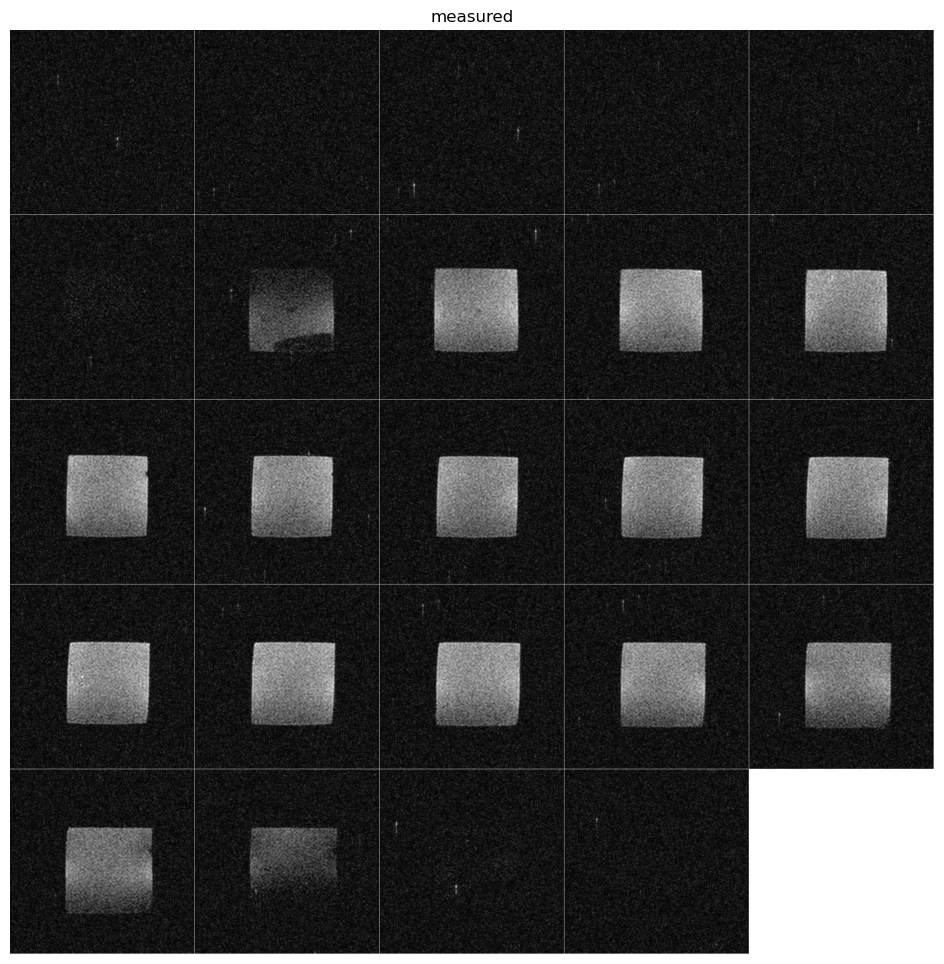

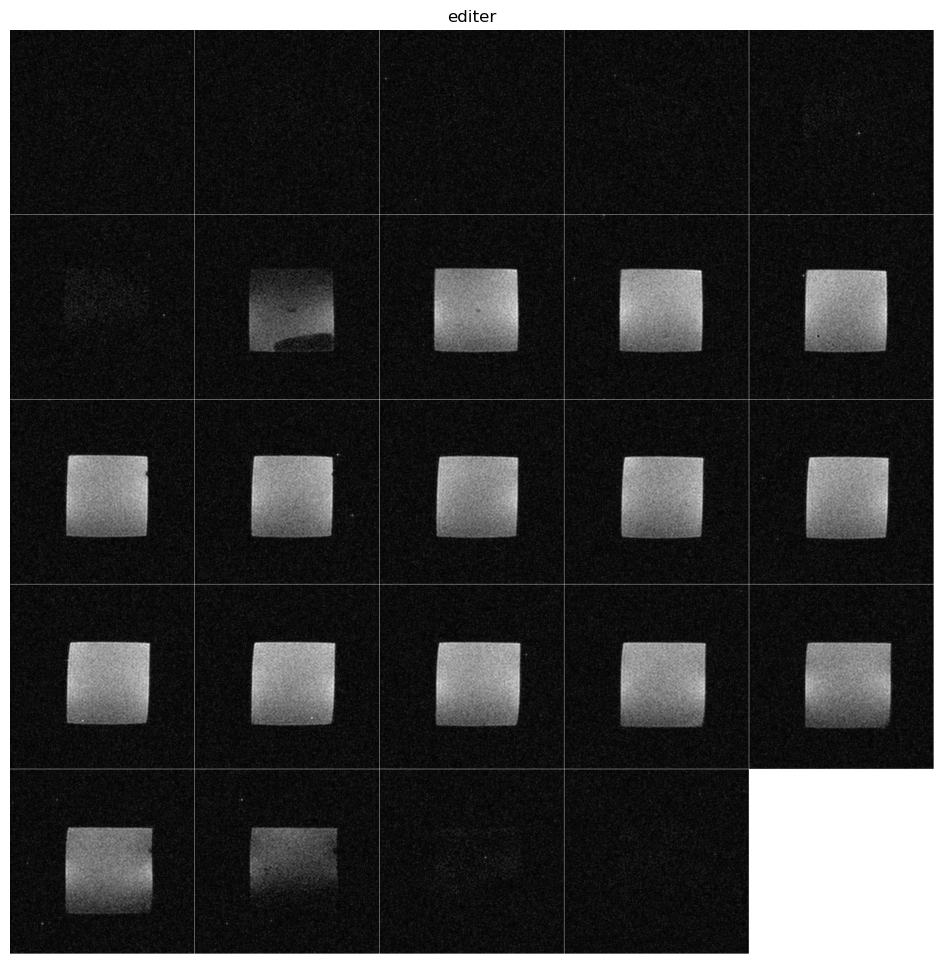

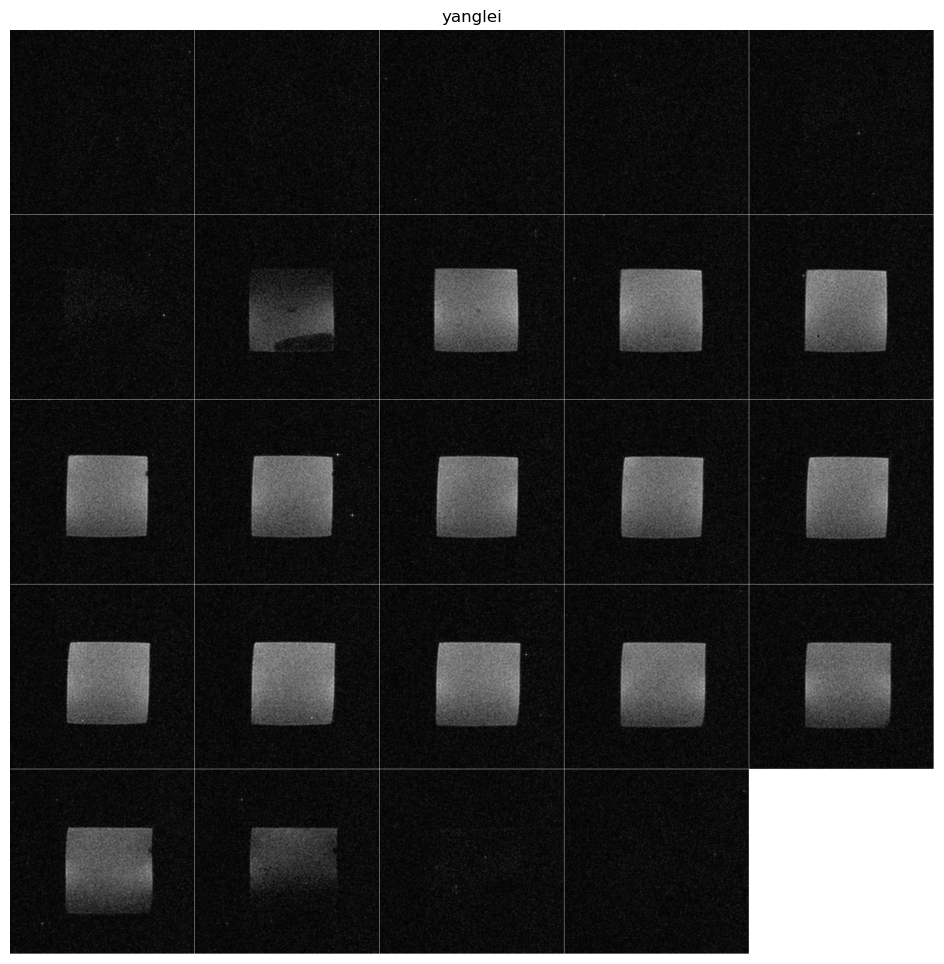

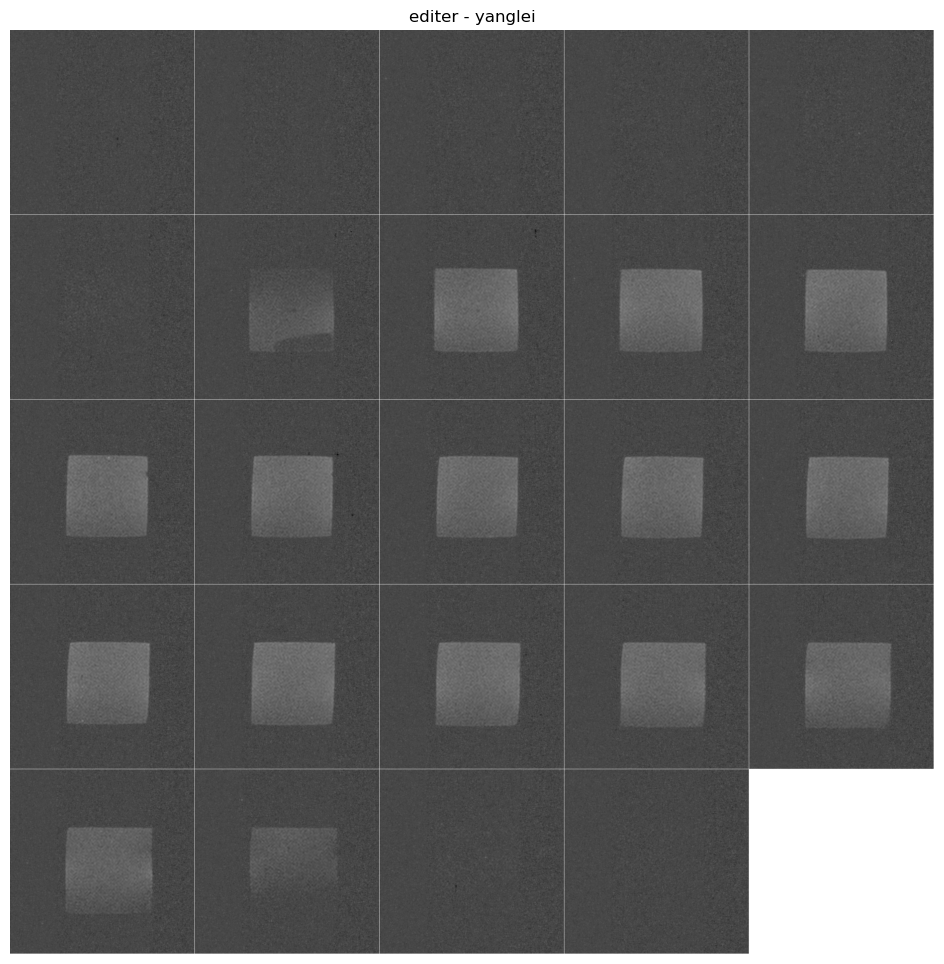

In [7]:
rois = {
    #        (row, col, x-off, y-off, width, height)
    '1n': (2, 1, 5, 5, 499, 79),
    '1s': (2, 1, 380, 315, 50, 50),
    # '2n' : (2,   0,    5,    5,     499,   79),
    # '2s' : (2,   0,   156,  170,    290,   180),
    '3n': (2, 3, 5, 5, 499, 79),
    '3s': (2, 3, 370, 305, 50, 50),
}

datas = load_data('scan')
measured = datas[0]
editer_denoised = editer(datas)
yanglei_denoised = yanglei(datas)


measured_images = np.array(reconImagesByFFT(measured, 512))
editer_images = np.array(reconImagesByFFT(editer_denoised, 512))
yanglei_images = np.array(reconImagesByFFT(yanglei_denoised, 512))


editer_diff = editer_images - measured_images
editer_diff -= editer_diff.min()

yanglei_diff = yanglei_images - measured_images
yanglei_diff -= yanglei_diff.min()

editer_vs_yanglei = editer_images - yanglei_images
editer_vs_yanglei -= editer_vs_yanglei.min()


# vis_square_annotate(editer_diff, title='EDITER diff')
# vis_square_annotate(yanglei_diff, title='yanglei diff')
vis_square_annotate(measured_images, title='measured')
vis_square_annotate(editer_images, title='editer')
vis_square_annotate(yanglei_images, title='yanglei')
vis_square_annotate(editer_vs_yanglei, title='editer - yanglei')
# vis_square_annotate(10*editer_vs_yanglei, title='10 * (editer-yanglei)')

plt.show()
